Hi! In this notebook we will do a little "how *Gradient Boosting* works" and find out answer for the question:
## "Will performance of GBDT model drop dramatically if we remove the first tree?"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import train_test_split

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Make dataset
We will use a very simple dataset: objects will come from 1D normal distribution, we will need to predict class $1$ if the object is positive and 0 otherwise.

In [6]:
X_all = np.random.randn(5000, 1)
y_all = (X_all[:, 0] > 0)*2 - 1

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.5, random_state=42)

In [7]:
X_all[0:5]

array([[-1.14357377],
       [-0.11509801],
       [ 1.64664133],
       [-1.30990955],
       [ 2.28979531]])

In [8]:
y_all

array([-1, -1,  1, ...,  1, -1, -1])

In [15]:
int(-1.14357377>0) *2-1

-1

In [18]:
int(1.64664133>0) * 2-1

1

(-4, 4)

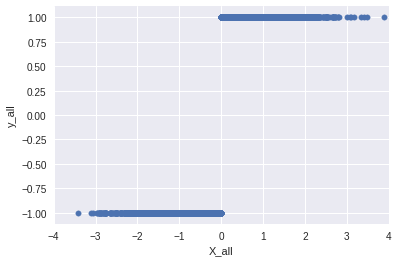

In [34]:
plt.scatter(X_all,y_all,s=30)
plt.xlabel('X_all')
plt.ylabel('y_all')
plt.xlim(-4,4)

The datast is really simple and can be solved with a single decision stump.

In [19]:
clf = DecisionTreeClassifier(max_depth=1)
clf.fit(X_train, y_train)

print ('Accuracy for a single decision stump: {}'.format(clf.score(X_test, y_test)))

Accuracy for a single decision stump: 1.0


In [80]:
clf.tree_.node_count

3

In [78]:
clf.tree_.weighted_n_node_samples

array([ 2500.,  1255.,  1245.])

In [82]:
clf.tree_.max_depth

1

In [58]:
X_test

array([[-0.71936528],
       [ 1.44747375],
       [ 0.48526842],
       ..., 
       [-0.7635853 ],
       [ 1.19081901],
       [ 1.89650464]])

In [57]:
clf.predict(X_test)

array([-1,  1,  1, ..., -1,  1,  1])

# Learn GBM

But we will need 800 trees in GBM to classify it correctly.

In [151]:
# For convenience we will use sklearn's GBM, the situation will be similar with XGBoost and others
clf = GradientBoostingClassifier(n_estimators=5000, learning_rate=0.01, max_depth=3, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict_proba(X_test)[:, 1]
print("Test logloss: {}".format(log_loss(y_test, y_pred)))

Test logloss: 0.0003139209450711925


In [152]:
clf.max_depth

3

In [110]:
clf.n_classes_

2

In [111]:
len([i for i in clf.staged_decision_function(X_test)])

5000

In [128]:
[i for i in clf.staged_decision_function(X_test)][0]

array([[-0.02792036],
       [ 0.01208028],
       [ 0.01208028],
       ..., 
       [-0.02792036],
       [ 0.01208028],
       [ 0.01208028]])

In [115]:
[i for i in clf.staged_decision_function(X_test)][0][0][0]

-0.027920361392175876

In [129]:
[i for i in clf.staged_decision_function(X_test)][0][1][0]

0.012080278618064304

In [125]:
cum_preds[0]

array([-0.02792036,  0.01208028,  0.01208028, ..., -0.02792036,
        0.01208028,  0.01208028])

In [153]:
def compute_loss(y_true, scores_pred):
    '''
        Since we use raw scores we will wrap log_loss 
        and apply sigmoid to our predictions before computing log_loss itself
    '''
    return log_loss(y_true, sigmoid(scores_pred))
    

'''
    Get cummulative sum of *decision function* for trees. i-th element is a sum of trees 0...i-1.
    We cannot use staged_predict_proba, since we want to maniputate raw scores
    (not probabilities). And only in the end convert the scores to probabilities using sigmoid
'''
cum_preds = np.array([x for x in clf.staged_decision_function(X_test)])[:, :, 0] 

print ("Logloss using all trees:           {}".format(compute_loss(y_test, cum_preds[-1, :])))
print ("Logloss using all trees but last:  {}".format(compute_loss(y_test, cum_preds[-2, :])))
print ("Logloss using all trees but first: {}".format(compute_loss(y_test, cum_preds[-1, :] - cum_preds[0, :])))

Logloss using all trees:           0.0003139209450711925
Logloss using all trees but last:  0.0003139209450711925
Logloss using all trees but first: 0.0003202006915733236


You can see that there is a difference, but not as huge as one could expect! Moreover, if we get rid of the first tree — overall model still works! 

If this is supprising for you — take a look at the plot of cummulative decision function depending on the number of trees.

In [130]:
y_test

array([-1,  1,  1, ..., -1,  1,  1])

In [131]:
len(y_test)

2500

In [132]:
y_test == 1

array([False,  True,  True, ..., False,  True,  True], dtype=bool)

In [158]:
cum_preds

array([[-0.02792036,  0.01208028,  0.01208028, ..., -0.02792036,
         0.01208028,  0.01208028],
       [-0.04764502,  0.0319602 ,  0.0319602 , ..., -0.04764502,
         0.0319602 ,  0.0319602 ],
       [-0.06717974,  0.05164565,  0.05164565, ..., -0.06717974,
         0.05164565,  0.05164565],
       ..., 
       [-8.07031771,  8.06231516,  8.06231516, ..., -8.07031771,
         8.06231516,  8.06231516],
       [-8.07031771,  8.06231516,  8.06231516, ..., -8.07031771,
         8.06231516,  8.06231516],
       [-8.07031771,  8.06231516,  8.06231516, ..., -8.07031771,
         8.06231516,  8.06231516]])

In [159]:
cum_preds[:, y_test == 1]

array([[ 0.01208028,  0.01208028,  0.01208028, ...,  0.01208028,
         0.01208028,  0.01208028],
       [ 0.0319602 ,  0.0319602 ,  0.0319602 , ...,  0.0319602 ,
         0.0319602 ,  0.0319602 ],
       [ 0.05164565,  0.05164565,  0.05164565, ...,  0.05164565,
         0.05164565,  0.05164565],
       ..., 
       [ 8.06231516,  8.06231516,  8.06231516, ...,  8.06231516,
         8.06231516,  8.06231516],
       [ 8.06231516,  8.06231516,  8.06231516, ...,  8.06231516,
         8.06231516,  8.06231516],
       [ 8.06231516,  8.06231516,  8.06231516, ...,  8.06231516,
         8.06231516,  8.06231516]])

In [160]:
cum_preds[:, y_test == 1][:,0]

array([ 0.01208028,  0.0319602 ,  0.05164565, ...,  8.06231516,
        8.06231516,  8.06231516])

In [155]:
len(cum_preds[0])

2500

In [157]:
len(cum_preds[:, y_test == 1][0])

1280

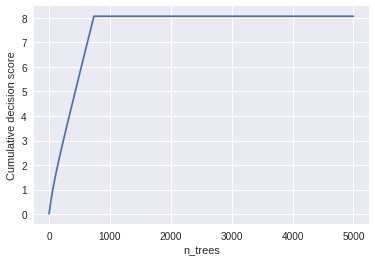

In [98]:
# Pick an object of class 1 for visualisation
plt.plot(cum_preds[:, y_test == 1][:, 0])

plt.xlabel('n_trees')
plt.ylabel('Cumulative decision score');

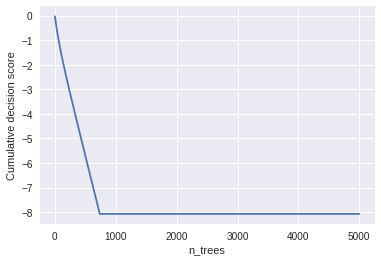

In [134]:
# Pick an object of class -1 for visualisation
plt.plot(cum_preds[:, y_test == -1][:, 0])

plt.xlabel('n_trees')
plt.ylabel('Cumulative decision score');

See, the decision function improves almost linearly untill about 800 iteration and then stops. And the slope of this line is connected with the learning rate, that we have set in GBM! 

If you remember the main formula of boosting, you can write something like:
    $$ F(x) = const + \sum\limits_{i=1}^{n}\gamma_i h_i(x) $$

In our case, $\gamma_i$ are constant and equal to learning rate $\eta = 0.01$. And look, it takes about $800$ iterations to get the score $8$, which means at every iteration score goes up for about $0.01$. It means that first 800 terms are approximately equal to $0.01$, and the following are almost $0$. 

We see, that if we drop the last tree, we lower $F(x)$ by $0$ and if we drop the first tree we lower $F(x)$ by $0.01$, which results in a very very little performance drop.  

So, even in the case of simple dataset which can be solved with single decision stump, in GBM we need to sum a lot of trees (roughly $\frac{1}{\eta}$) to approximate this golden single decision stump.

**To prove the point**, let's try a larger learning rate of $8$.

In [99]:
clf = GradientBoostingClassifier(n_estimators=5000, learning_rate=8, max_depth=3, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict_proba(X_test)[:, 1]
print("Test logloss: {}".format(log_loss(y_test, y_pred)))

Test logloss: 3.1501464044602086e-06


In [100]:
cum_preds = np.array([x for x in clf.staged_decision_function(X_test)])[:, :, 0] 

print ("Logloss using all trees:           {}".format(compute_loss(y_test, cum_preds[-1, :])))
print ("Logloss using all trees but last:  {}".format(compute_loss(y_test, cum_preds[-2, :])))
print ("Logloss using all trees but first: {}".format(compute_loss(y_test, cum_preds[-1, :] - cum_preds[0, :])))

Logloss using all trees:           3.1501464044602086e-06
Logloss using all trees but last:  2.978779247621635e-06
Logloss using all trees but first: 2.0944904530709247


That is it! Now we see, that it is crucial to have the first tree in the ensemble!

Even though the dataset is synthetic, the similar intuition will work with the real data, except GBM can diverge with high learning rates for a more complex dataset. If you want to play with a little bit more realistic dataset, you can generate it in this notebook with the following code:

`X_all, y_all = make_hastie_10_2(random_state=0)` 

and run the code starting from "Learn GBM".